In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from utils.encoder_utils import *
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
"""
References:
PCA: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
GMM: https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
Kmeans: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
Metrics: https://scikit-learn.org/stable/modules/clustering.html (from 2.3.11.5)
"""

'\nReferences:\nPCA: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html\nGMM: https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html\nKmeans: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html\nMetrics: https://scikit-learn.org/stable/modules/clustering.html (from 2.3.11.5)\n'

In [3]:
def plot_pca(transition_dim, role="prey", cluster=10):
    """
    Scree plot and 3D scatter plot of PCA components with clustering

    Input: transition dimension
    Output: plots
    """

    # standardize transition dimension
    scaler = StandardScaler()
    trans_fit = scaler.fit_transform(transition_dim)

    # fit PCA with as many components as possible
    pca = PCA(n_components=min(trans_fit.shape[0], trans_fit.shape[1]), random_state=0)
    X_pca = pca.fit_transform(trans_fit)

    # explained variance
    expl = pca.explained_variance_ratio_
    cumexpl = np.cumsum(expl)

    # components for 90% variance explanation
    k90 = int(np.searchsorted(cumexpl, 0.90) + 1)
    print("Components for 90% variance:", k90)

    # scree plot, explained variance and cumulative explained variance
    x = np.arange(1, len(expl) + 1)
    plt.figure(figsize=(8, 4.5))
    plt.plot(x, expl, marker='o', label="Explained variance ratio")
    plt.plot(x, cumexpl, marker='o', label="Cumulative explained variance")
    plt.xlabel("Component")
    plt.ylabel("Variance")
    plt.title(f"[{role.upper()}] Scree Plot (PCA)")
    plt.ylim(0, 1.02)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3D scatter plot of first 3 PCs with clustering
    gmm = GaussianMixture(n_components=cluster, covariance_type="full", random_state=0)
    labels = gmm.fit_predict(X_pca)

    X_3d = X_pca[:, :3]
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c=labels, s=15)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.set_title("Clusters in Transition Space")
    plt.tight_layout()
    plt.show()


def cluster_count(transitions, pca_components=12, n_fits=20, model="gmm"):
    """
    AIC/BIC plot to determine optimal cluster count

    Input: transition dimension, pca components, number of fits, model type
    Output: AIC/BIC plot
    """

    # reduce dimensionality with PCA
    pca = PCA(n_components=pca_components, random_state=0)
    X_pca = pca.fit_transform(transitions)

    aic_list = []
    bic_list = []

    # try different cluster counts
    for i in tqdm(range(n_fits)):
        if model == "gmm":
            # fit Gaussian Mixture Model
            gmm = GaussianMixture(n_components=i+1, covariance_type="full", random_state=0)
            gmm.fit(X_pca)

            aic = gmm.aic(X_pca)
            bic = gmm.bic(X_pca)
        else:
            # fit KMeans
            kmeans = KMeans(n_clusters=i+1, random_state=0)
            kmeans.fit(X_pca)

            # Inertia is the sum of squared distances to cluster centers
            inertia = kmeans.inertia_
            n_samples, n_features = X_pca.shape
            n_clusters = i + 1

            # calculate AIC and BIC for KMeans
            aic = inertia + 2 * n_clusters * n_features
            bic = inertia + np.log(n_samples) * n_clusters * n_features

        aic_list.append(aic)
        bic_list.append(bic)

    # plot AIC and BIC curves
    ks = np.arange(1, n_fits + 1)
    plt.figure(figsize=(7, 4))
    plt.plot(ks, aic_list, marker="o", label="AIC")
    plt.plot(ks, bic_list, marker="o", label="BIC")
    plt.xlabel("Number of components")
    plt.ylabel("Information criterion")
    plt.title(f"Model selection")
    plt.legend()
    plt.tight_layout()
    plt.show()


def calculate_cluster_metrics(model, pca_fit, labels):
    """
    Calculate various cluster evaluation metrics

    Input: fitted model, PCA-transformed data, cluster labels
    Output: prints cluster evaluation metrics
    """
    db = davies_bouldin_score(pca_fit, labels)
    print("Davies–Bouldin:", db)

    ch = calinski_harabasz_score(pca_fit, labels)
    print("Calinski–Harabasz:", ch)

    sil = silhouette_score(pca_fit, labels)
    print("Silhouette score:", sil)

    ll = model.score(pca_fit)   # mean log-likelihood
    print("Avg log-likelihood:", ll)

    probs = model.predict_proba(pca_fit)
    entropy = -np.sum(probs * np.log(probs + 1e-8), axis=1)
    print("Mean entropy:", entropy.mean())

    centers = model.means_
    center_dists = pdist(centers)
    print("Mean center distance:", center_dists.mean())

    counts = np.bincount(labels)
    freqs = counts / counts.sum()
    print("Cluster frequencies:", freqs)
    print("Std of frequencies:", freqs.std())

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

window_len = 10 # load expert tensors with windows length 10
window_path = rf'..\data\1. Data Processing\processed\video\expert_tensors\windows\{window_len} windows'
init_pool_path = rf'..\data\1. Data Processing\processed\init_pool'

pred_files = []
prey_files = []

for file in os.listdir(window_path):
    if file.startswith("pred"):
        # load predator tensors
        pred_tensor = torch.load(os.path.join(window_path, file))
        pred_files.append(pred_tensor)
    elif file.startswith("prey"):
        # load prey tensors
        prey_tensor = torch.load(os.path.join(window_path, file))
        prey_files.append(prey_tensor)

exp_pred_tensor = torch.cat(pred_files, dim=0).type(torch.float32).to(device)
exp_prey_tensor = torch.cat(prey_files, dim=0).type(torch.float32).to(device)

print("Pred Tensor Shape:", exp_pred_tensor.shape)
print("Prey Tensor Shape:", exp_prey_tensor.shape)

Pred Tensor Shape: torch.Size([793, 10, 1, 32, 5])
Prey Tensor Shape: torch.Size([793, 10, 32, 32, 6])


epoch 010: loss=22.790121 sim=0.0452 std=1.3228 cov=0.3635 std_mean=0.339
epoch 020: loss=21.870003 sim=0.0333 std=1.2731 cov=0.3879 std_mean=0.363
epoch 030: loss=21.265532 sim=0.0391 std=1.2086 cov=0.4316 std_mean=0.396
epoch 040: loss=20.739977 sim=0.0382 std=1.1599 cov=0.4771 std_mean=0.420
epoch 050: loss=20.492693 sim=0.0422 std=1.1323 cov=0.4907 std_mean=0.434
epoch 060: loss=20.216650 sim=0.0418 std=1.1186 cov=0.4783 std_mean=0.441
epoch 070: loss=19.754391 sim=0.0436 std=1.0695 cov=0.5241 std_mean=0.465
epoch 080: loss=19.429123 sim=0.0438 std=1.0501 cov=0.5164 std_mean=0.475
epoch 090: loss=19.301771 sim=0.0484 std=1.0258 cov=0.5409 std_mean=0.487
epoch 100: loss=18.813501 sim=0.0408 std=1.0083 cov=0.5339 std_mean=0.496
epoch 110: loss=19.262024 sim=0.0517 std=0.9844 cov=0.6408 std_mean=0.508
epoch 120: loss=18.519775 sim=0.0464 std=0.9810 cov=0.5290 std_mean=0.509
epoch 130: loss=18.377110 sim=0.0472 std=0.9488 cov=0.5930 std_mean=0.526
epoch 140: loss=18.232212 sim=0.0476 s

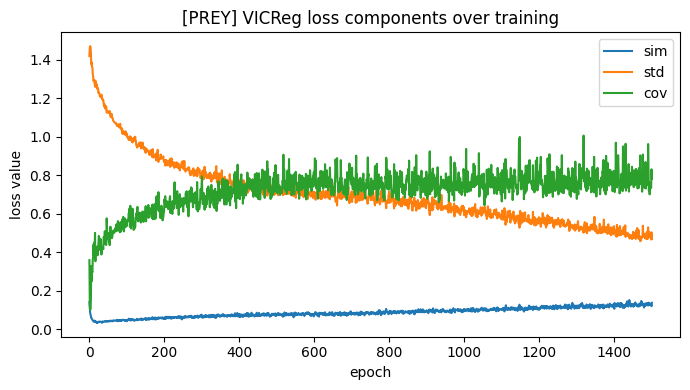

Prey Encoder trained & frozen.

epoch 010: loss=23.935577 sim=0.0515 std=1.3054 cov=0.6136 std_mean=0.347
epoch 020: loss=22.776508 sim=0.0350 std=1.3320 cov=0.3844 std_mean=0.334
epoch 030: loss=22.946079 sim=0.0386 std=1.3547 cov=0.3323 std_mean=0.323
epoch 040: loss=22.289324 sim=0.0293 std=1.3050 cov=0.3962 std_mean=0.347
epoch 050: loss=22.981800 sim=0.0675 std=1.2697 cov=0.4500 std_mean=0.365
epoch 060: loss=22.495653 sim=0.0519 std=1.2880 cov=0.3757 std_mean=0.356
epoch 070: loss=22.400797 sim=0.0594 std=1.2372 cov=0.4718 std_mean=0.381
epoch 080: loss=21.571672 sim=0.0311 std=1.2289 cov=0.4720 std_mean=0.386
epoch 090: loss=21.704376 sim=0.0458 std=1.2609 cov=0.3290 std_mean=0.370
epoch 100: loss=21.928471 sim=0.0530 std=1.2260 cov=0.4424 std_mean=0.387
epoch 110: loss=22.170645 sim=0.0643 std=1.1962 cov=0.5244 std_mean=0.402
epoch 120: loss=22.138672 sim=0.0552 std=1.2154 cov=0.5052 std_mean=0.392
epoch 130: loss=21.393400 sim=0.0434 std=1.2102 cov=0.4313 std_mean=0.395
epoch 

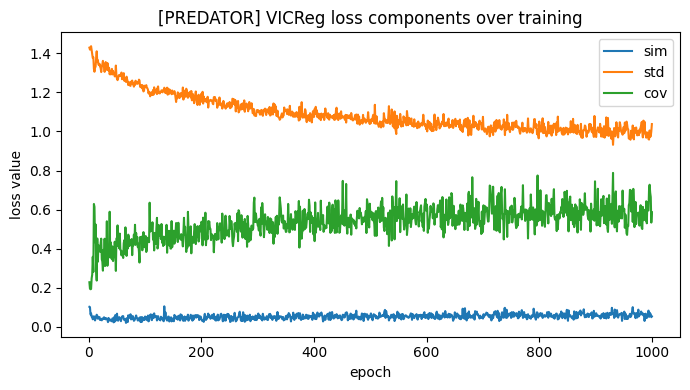

Predator Encoder trained & frozen.


In [5]:
# initialize augmentation module for encoder training
aug = TrajectoryAugmentation(noise_std=0.01, neigh_drop=0.10, feat_drop=0.05).to(device)

# initialize tranistion encoder and projector for prey, train it
prey_encoder = TransitionEncoder(features=5, embd_dim=32, z=32).to(device)
prey_projector = VicRegProjector(input_dim=64).to(device)
prey_optimizer = torch.optim.Adam(list(prey_encoder.parameters()) + list(prey_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(prey_encoder, prey_projector, aug=aug, exp_tensor=exp_prey_tensor, epochs=1500, optimizer=prey_optimizer, role="prey")

# freeze prey encoder
for p in prey_encoder.parameters():
    p.requires_grad = False 

print("Prey Encoder trained & frozen.\n")

# initialize tranistion encoder and projector for predator, train it
pred_encoder = TransitionEncoder(features=4, embd_dim=32, z=32).to(device)
pred_projector = VicRegProjector(input_dim=64).to(device)
pred_optimizer = torch.optim.Adam(list(pred_encoder.parameters()) + list(pred_projector.parameters()), lr=1e-3, weight_decay=1e-6)
train_encoder(pred_encoder, pred_projector, aug=aug, exp_tensor=exp_pred_tensor, epochs=1000, optimizer=pred_optimizer, role="predator")

# freeze predator encoder
for p in pred_encoder.parameters():
    p.requires_grad = False

print("Predator Encoder trained & frozen.")

In [6]:
# init scaler
scaler = StandardScaler()

# get prey transition dimensions from prey encoder
prey_states = exp_prey_tensor[..., :5]
_, trans_prey = prey_encoder(prey_states)
x_prey = trans_prey.detach().cpu().numpy()
prey_trans_dim = x_prey.reshape(-1, x_prey.shape[-1])
scaled_prey = scaler.fit_transform(prey_trans_dim)

# get predator transition dimensions from predator encoder
pred_states = exp_pred_tensor[..., :4]
_, trans_pred = pred_encoder(pred_states)
x_pred = trans_pred.detach().cpu().numpy()
pred_trans_dim = x_pred.reshape(-1, x_pred.shape[-1])  
scaled_pred = scaler.fit_transform(pred_trans_dim)

## Prey

Components for 90% variance: 11


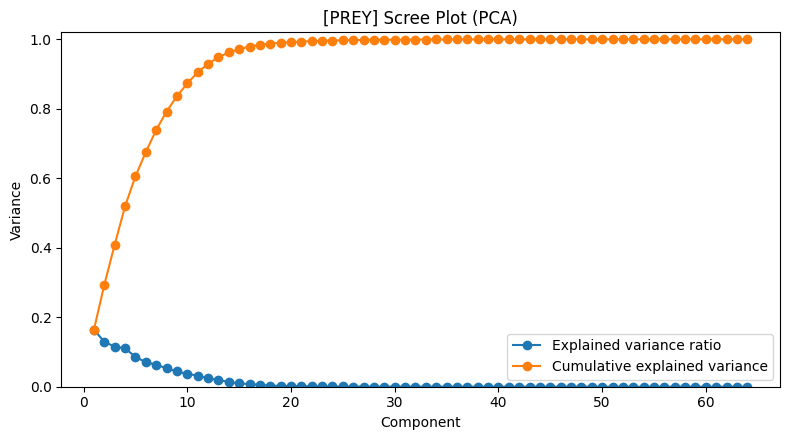

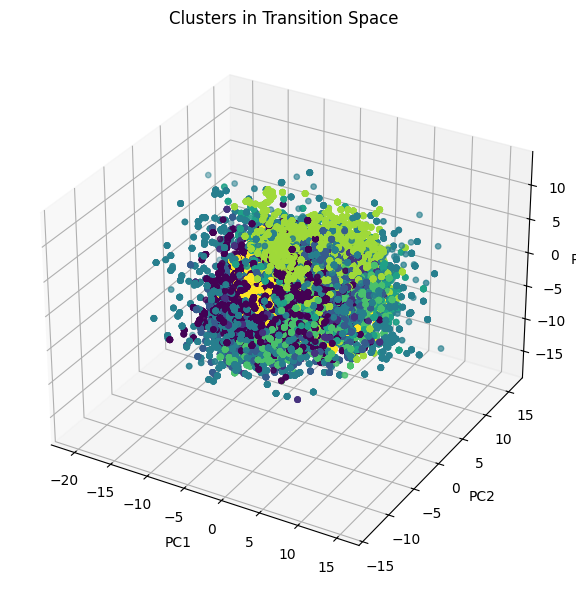

In [7]:
# plot Screeplot and PCA clusters for prey (cluster=8 is determine as optimal)
plot_pca(prey_trans_dim, role="prey", cluster=8)

100%|██████████| 20/20 [06:02<00:00, 18.15s/it]


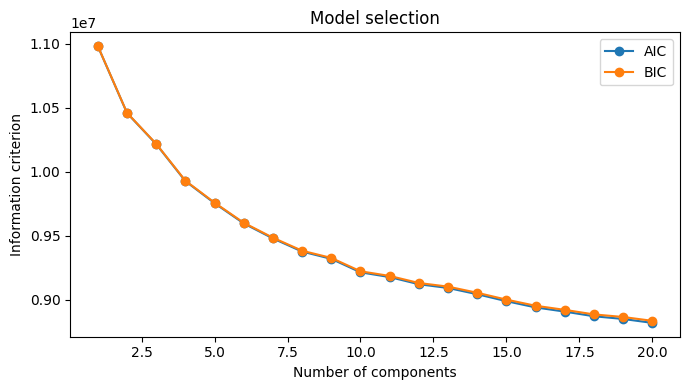

In [8]:
# determine optimal cluster count for prey using gmm
cluster_count(scaled_prey, pca_components=11, n_fits=20, model="gmm")

100%|██████████| 20/20 [00:05<00:00,  3.63it/s]


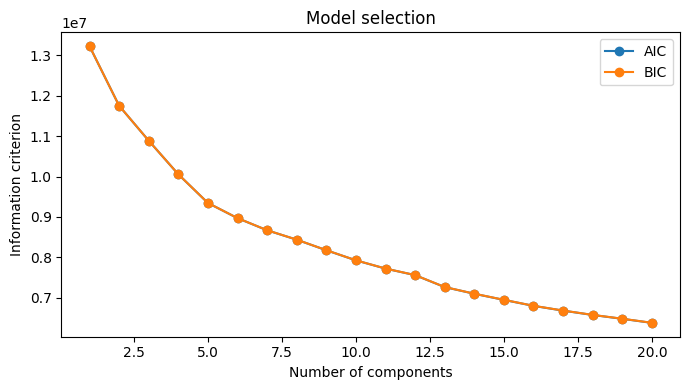

In [9]:
# determine optimal cluster count for prey using kmeans
cluster_count(scaled_prey, pca_components=11, n_fits=20, model="kmeans")

In [10]:
# fit PCA and GMM with optimal cluster count for prey
pca = PCA(n_components=11, random_state=0)
X_pca = pca.fit_transform(scaled_prey)

gmm = GaussianMixture(n_components=8, covariance_type="full", random_state=0)
labels = gmm.fit_predict(X_pca)

# calculate cluster evaluation metrics
calculate_cluster_metrics(gmm, X_pca, labels)

Davies–Bouldin: 4.725190270854176
Calinski–Harabasz: 5947.822265625
Silhouette score: -0.023887963965535164
Avg log-likelihood: -20.527754
Mean entropy: 0.21987413
Mean center distance: 4.413451717487379
Cluster frequencies: [0.20722555 0.06140097 0.14608291 0.11402287 0.11318218 0.12556484
 0.1060407  0.12647996]
Std of frequencies: 0.038523513513994856


## Predator

Components for 90% variance: 11


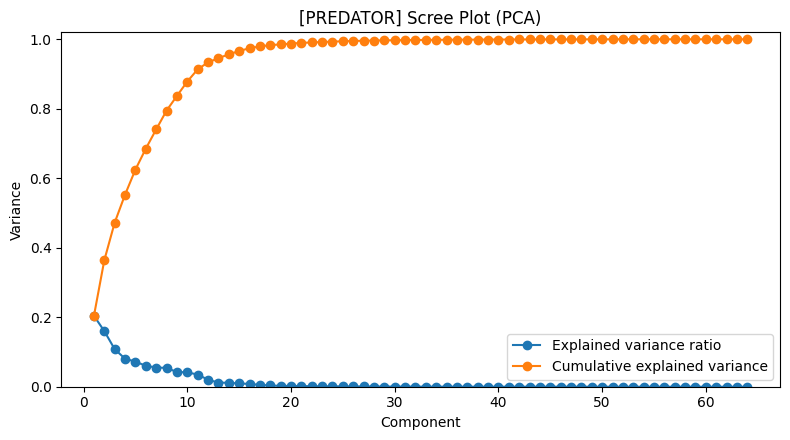

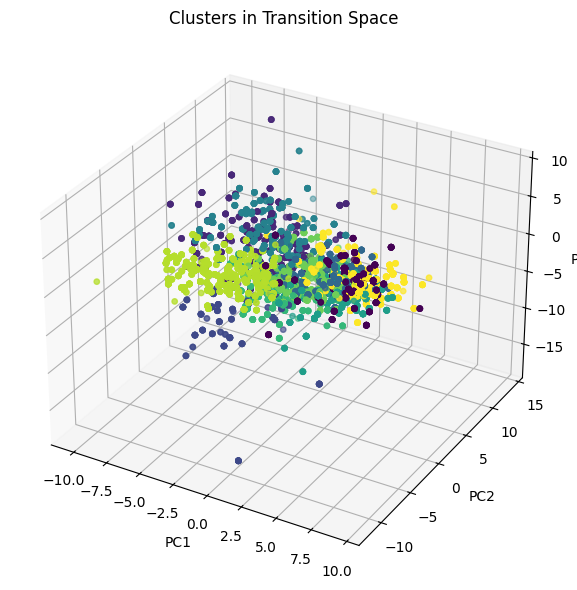

In [11]:
# plot Screeplot and PCA clusters for predator (cluster=10 is determine as optimal)
plot_pca(pred_trans_dim, role="predator", cluster=10)

100%|██████████| 20/20 [00:08<00:00,  2.32it/s]


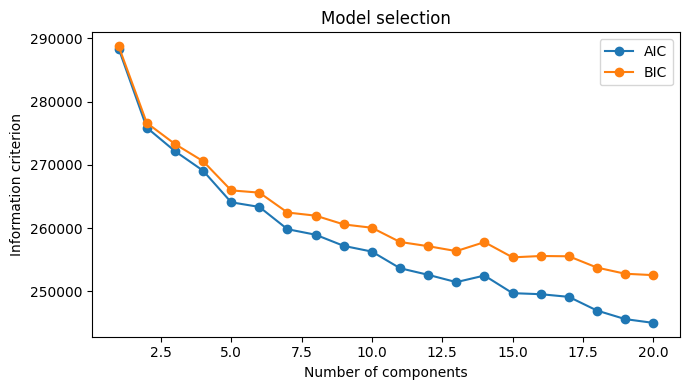

In [12]:
# determine optimal cluster count for predator using gmm
cluster_count(scaled_pred, pca_components=9, n_fits=20, model="gmm")

100%|██████████| 20/20 [00:00<00:00, 84.91it/s]


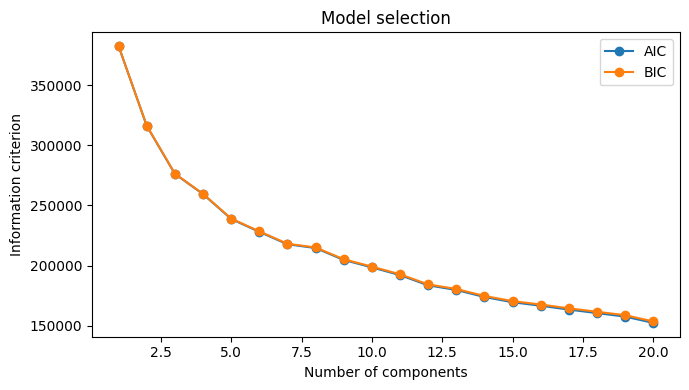

In [13]:
# determine optimal cluster count for predator using kmeans
cluster_count(scaled_pred, pca_components=9, n_fits=20, model="kmeans")

In [14]:
# fit PCA and GMM with optimal cluster count for predator
pca = PCA(n_components=9, random_state=0)
X_pca = pca.fit_transform(scaled_pred)

gmm = GaussianMixture(n_components=10, covariance_type="full", random_state=0)
labels = gmm.fit_predict(X_pca)

# calculate cluster evaluation metrics
calculate_cluster_metrics(gmm, X_pca, labels)

Davies–Bouldin: 2.616335792380946
Calinski–Harabasz: 457.4466857910156
Silhouette score: 0.04854138195514679
Avg log-likelihood: -17.87659
Mean entropy: 0.1997799
Mean center distance: 7.100284415291389
Cluster frequencies: [0.09513801 0.07047779 0.1636542  0.14627995 0.03446826 0.07187894
 0.14095558 0.110971   0.07440101 0.09177526]
Std of frequencies: 0.03833375784067588
